# Lottery ticket hypothesis test

#### Here is a notebook that aims to find the 'lottery ticket', which is an hypothesis that says that there exists a sub-neural net within your whole NN that could do the same results with significantly less connections

## Imports

In [1]:
import torch
import torchvision
import codecarbon
from codecarbon import EmissionsTracker
import pandas as pd

## Base functions and class

We here create the base model class and the base functions to load the data, train and test the model.

In [2]:
def load_mnist(): # Load MNIST dataset
    transform = torchvision.transforms.Compose([ # Preprocess images
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) # Load training set
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) # Create dataloader
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Load test set 
    testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2) # Create dataloader
    return trainloader, testloader

class MNIST_Model(torch.nn.Module): # Define model
    def __init__(self):
        super(MNIST_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x): # Forward pass
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train_model(model, trainloader, criterion, optimizer, epochs=2): # Train model
    for epoch in range(epochs): # Loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): # Get the inputs
            inputs, labels = data
            optimizer.zero_grad() # Zero the parameter gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Optimize & update weights
            running_loss += loss.item()  # Print statistics
            if i % 2000 == 1999: 
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}') 
                running_loss = 0.0
    print('Finished Training')

def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient tracking
        for data in testloader: # Loop over the test set
            images, labels = data # Get the inputs
            outputs = model(images) # Forward pass
            _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability
            total += labels.size(0) # Total number of labels
            correct += (predicted == labels).sum().item() # Number of correct predictions
    acc = 100 * correct / total # Compute accuracy
    #print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')

    return acc

## Train a base model to compare afterwards

In [3]:
# Load the data

trainloader, testloader = load_mnist()

# Define the model

model = MNIST_Model() # Create model

# Define the loss function and optimizer

criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Optimizer

# Train the model

train_model(model, trainloader, criterion, optimizer) # Train the model

# Test the model

model_acc = test_model(model, testloader) # Test the model

[1, 2000] loss: 0.919
[1, 4000] loss: 0.211
[1, 6000] loss: 0.136
[1, 8000] loss: 0.119
[1, 10000] loss: 0.097
[1, 12000] loss: 0.091
[1, 14000] loss: 0.071
[2, 2000] loss: 0.064
[2, 4000] loss: 0.064
[2, 6000] loss: 0.066
[2, 8000] loss: 0.061
[2, 10000] loss: 0.064
[2, 12000] loss: 0.048
[2, 14000] loss: 0.055
Finished Training


## Define the pruning method

We will create a class based on the torch.nn.utils.prune.BasePruningMethod which will permit us to create a mask on the weight in order to set them to zero

We will also have a small function that counts our zero parameter to verify that it is working

In [4]:
from torch.nn.utils import prune # This module provides an interface for model pruning  

class PercentagePruning(prune.BasePruningMethod): # This class aims to prune a percentage of the weights (the ones with the lowest absolute value)
    PRUNING_TYPE = 'unstructured' # Unstructured pruning

    def __init__(self, percentage): # Constructor
        self.percentage = percentage

    def compute_mask(self, tensor, default_mask): # This function computes the mask for the tensor
        
        mask = default_mask.clone()
        numel = mask.numel()

        if numel == 0:
            return mask
        
        weight_values = tensor.flatten().abs() # Get the absolute value of the weights

        k = int(numel * self.percentage) # Compute the number of weights to prune

        # find threshold value

        threshold = weight_values.kthvalue(k).values # Compute the threshold value for pruning the correct percentage of weights

        # generate mask

        return torch.abs(tensor) > threshold # Generate the mask
        
    
def compute_parameters_number(model, eps = 1e-7): # This function computes the number of parameters different from zero in the model
    weight_values = torch.cat([tensor.flatten() for name, tensor in model.state_dict().items() if 'weight' in name]) # Get the weights of the model
    return sum(weight_values.abs() > eps).item() # Return the number of weights different from zero


## Pruning our model

Let's try our pruning method before iterating with it later for our hypothesis

In [5]:
import copy # This module provides generic shallow and deep copy operations
pruned_model = copy.deepcopy(model) # Create a copy of the model

# parameters to prune
parameters_to_prune = [] # List of parameters to prune

for name, module in pruned_model.named_modules(): # Loop over the modules of the model
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear): # If the module is a convolutional or linear layer
        parameters_to_prune.append((module, 'weight')) # Add the weights of the module to the list of parameters to prune

prune.global_unstructured( # Prune the model
    parameters_to_prune,
    pruning_method=PercentagePruning,
    percentage=0.5,
)

# prune remove
for module, name in parameters_to_prune: # Loop over the parameters to prune
    prune.remove(module, name) # Apply the mask to the weights

print(f'Number of parameters in the original model: {compute_parameters_number(model)}') 
print(f'Number of parameters in the pruned model: {compute_parameters_number(pruned_model)}')

Number of parameters in the original model: 44190
Number of parameters in the pruned model: 22095


#### Now, that it effectively set the right amount of weight, let's compare the losses and fine_tune the model too

In [6]:
pruned_before_retrain_acc = test_model(pruned_model, testloader) # Test the pruned model

## Pytorch's problem

#### Pytorch doesn't support the 'true' removal of the weights, so in order to handle this problem we will modify a little the training process.

We have to way of implementing this :

-First, create a mask where we note who are the already pruned weights (i.e the zeros) and then while computing the gradient we set those weights' gradients to zero so that they won't be updated. However, this could not work with certain type of optimizer / loss function where the weights would still be updated.

You can check this implementation below but we will use another one which is pretty similar :

-We create the same mask and instead of preventing the update, we will simply set them back to zero after the update.

In [7]:
def train_pruned_model_mask(model, trainloader, criterion, optimizer, epochs=2, eps = 1e-7): #eps because of the floating point inaccuracy
    # this method works only with certain optimizer / loss function as sometimes the weights will still be updated even if the gradient is zero
    locked_masks = {n: torch.abs(w) < eps for n, w in model.named_parameters() if n.endswith('weight')}  # Get a copy of the already pruned weights
    for epoch in range(epochs): 
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0): 
            inputs, labels = data 
            optimizer.zero_grad() # Zero the parameter gradients
            outputs = model(inputs)# Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Backward pass
            for n, w in model.named_parameters(): # Loop over the parameters                                                                                                                                                                           
                if w.grad is not None and n in locked_masks: # If the parameter is in the locked masks                                                                                                                                                                                   
                    w.grad[locked_masks[n]] = 0 # Set the gradient to zero
            optimizer.step() # Optimize & update weights
            running_loss += loss.item()
        if epoch % 2 == 1:
            print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0
    print('Finished Training')

def train_pruned_model_copy(model, trainloader, criterion, optimizer, epochs=2, eps = 1e-7): #copy zero weights and paste them back after the optimizer step
    locked_masks = {n: torch.abs(w) < eps for n, w in model.named_parameters() if n.endswith('weight')} # Get a copy of the already pruned weights
    for epoch in range(epochs): # Loop over the dataset multiple times
        running_loss = 0.0 # Initialize the running loss
        for _, data in enumerate(trainloader, 0): # Get the inputs
            inputs, labels = data # Zero the parameter gradients
            optimizer.zero_grad() # Forward pass
            outputs = model(inputs) # Compute loss
            loss = criterion(outputs, labels) # Backward pass
            loss.backward() # Optimize & update weights
            optimizer.step() # Weights update

            for n, w in model.named_parameters(): # Loop over the parameters
                if n in locked_masks: # If the parameter is in the locked masks 
                    w.data[locked_masks[n]] = 0 # Set the weights back to zero

            running_loss += loss.item()
        if epoch % 2 == 1:
            print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0
    print('Finished Training')

In [8]:
# train the pruned model a few epochs

train_pruned_model_copy(pruned_model, trainloader, criterion, optimizer, epochs=2) # Train the pruned model a few epochs 

pruned_fine_tuned_acc = test_model(pruned_model, testloader)  # Test the pruned model

[2] loss: 0.337
Finished Training


## Compare and check pruning

In [9]:
first_results = pd.DataFrame({
    'Model': ['Original', 'Pruned', 'Pruned + Fine-Tuned'],
    'Accuracy': [model_acc, pruned_before_retrain_acc, pruned_fine_tuned_acc],
    'Params': [compute_parameters_number(model), compute_parameters_number(pruned_model), compute_parameters_number(pruned_model)]
})
print(first_results)

                 Model  Accuracy  Params
0             Original     98.41   44190
1               Pruned     98.37   22095
2  Pruned + Fine-Tuned     98.37   22095


#### We can already be happy with the results as we lost nearly no accuracy with our pruning, meaning that removing the less magnitude weights doesn't affect accuracy much

## Lottery ticket

#### To check for lottery tickets, we will simply iterate the pruning over and over while always fine-tuning the pruned model so that we identify each time who are the most important weights to keep in our architecture.

In [10]:
def find_lottery_ticket(model_to_prune, criterion, train_loader, test_loader, pruning_percentage = 0.2, loops = 5, epochs = 1): # Find the lottery ticket
    model = copy.deepcopy(model_to_prune) # Create a copy of the model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer
    accuracies = [test_model(model, test_loader)] # Test the model
    param_numbers = [compute_parameters_number(model)] # Compute the number of parameters
    print(f'Epochs: {0}, Accuracy: {accuracies[-1]}, Parameters: {param_numbers[-1]}') # Print the results
    for _ in range(loops): # Loop over the number of loops
        parameters_to_prune = [] # List of parameters to prune
        for name, module in model.named_modules(): # Loop over the modules of the model
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear): # If the module is a convolutional or linear layer
                parameters_to_prune.append((module, 'weight')) # Add the weights of the module to the list of parameters to prune
        percentage = 1 - (1 - pruning_percentage) ** (_ + 1) # Because we canno't really remove the weights, we can only prune a larger percentage of the weights each time, by carefully never updating previous pruned weights
        print(f'Pruning {percentage * 100:.2f}% of the weights') 
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=PercentagePruning,
            percentage=percentage,
        )
        for module, name in parameters_to_prune: # Loop over the parameters to prune
            prune.remove(module, name) # Apply the mask to the weights
        
        param_numbers.append(compute_parameters_number(model)) # Compute the number of parameters
        train_pruned_model_copy(model, train_loader, criterion, optimizer, epochs) # Fine-tune the model
        accuracies.append(test_model(model, test_loader)) # Test the model

        #save the model
        torch.save(model.state_dict(), f"lottery_models/model_{_}.pt")


        print(f'Epochs: {_+1}, Accuracy: {accuracies[-1]:.3f}, Parameters: {param_numbers[-1]}')

    return model, accuracies, param_numbers

#### Perform the lottery ticket algorithm

In [11]:
tracker = EmissionsTracker(save_to_file=False, log_level='critical') # Create the tracker

tracker.start() # Start the tracker

lottery_ticket, accuracies, param_numbers = find_lottery_ticket(model, torch.nn.CrossEntropyLoss(), trainloader, testloader, pruning_percentage=0.5, loops=10, epochs=1) # Find the lottery ticket

pruning_emissions = tracker.stop() # Stop the tracker

Epochs: 0, Accuracy: 98.41, Parameters: 44190
Pruning 50.00% of the weights


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Finished Training
Epochs: 1, Accuracy: 98.790, Parameters: 22095
Pruning 75.00% of the weights
Finished Training
Epochs: 2, Accuracy: 98.920, Parameters: 11048
Pruning 87.50% of the weights


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Finished Training
Epochs: 3, Accuracy: 98.920, Parameters: 5524
Pruning 93.75% of the weights
Finished Training
Epochs: 4, Accuracy: 98.540, Parameters: 2762
Pruning 96.88% of the weights
Finished Training


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Epochs: 5, Accuracy: 98.390, Parameters: 1381
Pruning 98.44% of the weights


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Finished Training
Epochs: 6, Accuracy: 97.350, Parameters: 691
Pruning 99.22% of the weights
Finished Training
Epochs: 7, Accuracy: 94.150, Parameters: 346
Pruning 99.61% of the weights


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Finished Training
Epochs: 8, Accuracy: 85.060, Parameters: 173
Pruning 99.80% of the weights


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Finished Training
Epochs: 9, Accuracy: 54.630, Parameters: 87
Pruning 99.90% of the weights


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Finished Training
Epochs: 10, Accuracy: 31.680, Parameters: 44


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

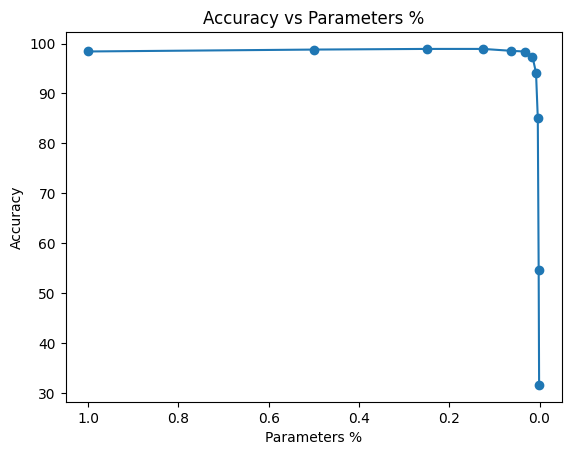

Pruning emissions: 0.0002813856342441691


In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.asarray(param_numbers) / compute_parameters_number(model), accuracies, marker='o') # Plot the results
plt.gca().invert_xaxis() # Invert the x-axis
plt.xlabel('Parameters %')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Parameters %')
plt.show()

print(f'Pruning emissions: {pruning_emissions}')


#### The results are really satisfying and way above the expectations ! Now let's check if it boosts the inference time or if we can't yet handle sparse matrices multiplications within Pytorch

In [13]:
#compare inference time for the original model and the pruned model

import time

def inference_time(model, testloade, num_loops = 100, warmup = 10):

    #warmup
    for i, data in enumerate(testloader, 0): #warmup to avoid the first iterations to be slower
        if i == warmup: # Stop the loop after warmup
            break
        inputs, _ = data
        model(inputs)

    start = time.time()
    tracker = codecarbon.EmissionsTracker(log_level='critical', save_to_file=False) # Create the tracker
    tracker.start() # Start the tracker
    for i, data in enumerate(testloader, 0):  # Loop over the test set
        if i == num_loops: # Stop the loop after num_loops
            break
        inputs, _ = data
        model(inputs)
    total_em = tracker.stop() # Stop the tracker
    end = time.time() # End time

    return (end - start) / num_loops, total_em / num_loops

original_inference_time, original_emissions = inference_time(model, testloader)

pruned_inference_time, pruned_emissions = inference_time(lottery_ticket, testloader)

print(f'Original inference time: {original_inference_time:.3f}s')

print(f'Pruned inference time: {pruned_inference_time:.3f}s')



Original inference time: 0.135s
Pruned inference time: 0.104s


#### Let's try with a more realistic model, the 4th one

In [15]:
#load model
pruned_model_4 = MNIST_Model()
pruned_model_4.load_state_dict(torch.load("lottery_models/model_4.pt"))

#check for inference time
pruned_inference_time_4, pruned_emissions_4 = inference_time(pruned_model_4, testloader)

print(f'Pruned inference time: {pruned_inference_time_4:.3f}s')

Pruned inference time: 0.129s


## As expected, the inference time doesn't change very much despite the large amount of pruned weights

In [16]:
#model size
import os
def model_size(model):
    torch.save(model.state_dict(), 'model.pt')
    size = os.path.getsize('model.pt')
    os.remove('model.pt')
    return size

print(f'Original model size: {model_size(model)} bytes')
print(f'Pruned model size: {model_size(lottery_ticket)} bytes')
print(f'Pruned model size 4: {model_size(pruned_model_4)} bytes')

Original model size: 180956 bytes
Pruned model size: 180956 bytes
Pruned model size 4: 180956 bytes


### Maybe we could try quantizing the zero weights 
